<a href="https,//colab.research.google.com/github/deedf/covid_data/blob/main/covid_vaccine_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# First run this and restart the runtime.

%pip install matplotlib pandas ckanapi --upgrade


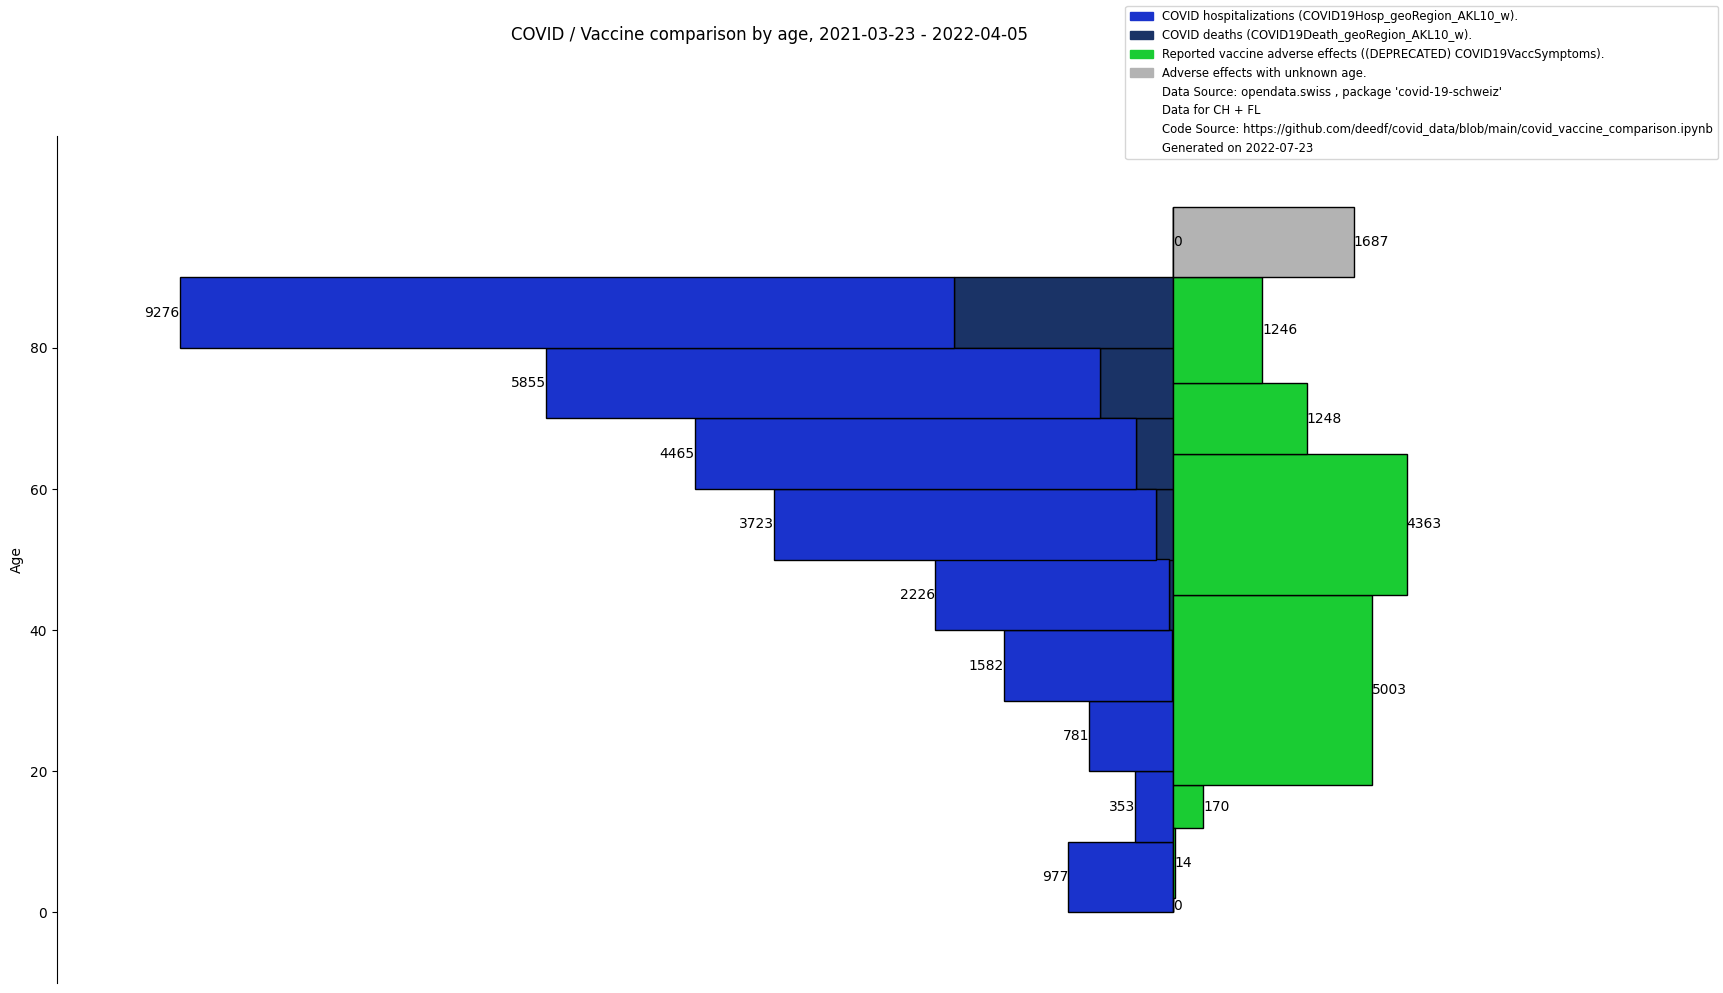

In [24]:
from collections import namedtuple
from datetime import date, datetime
from typing import Any, Dict, List, Tuple

import matplotlib.pyplot as plt
import pandas as pd
from ckanapi import RemoteCKAN
from matplotlib.patches import Rectangle


DATASET_NAME = "covid-19-schweiz"
CKAN_API_URL = "https://ckan.opendata.swiss/"

START_DATE = date(2021, 3, 23)
END_DATE = date(2022, 4, 5)
DEATH_COLOR = (0.1, 0.2, 0.4)
HOSP_COLOR = (0.1, 0.2, 0.8)
SYMPTOM_COLOR = (0.1, 0.8, 0.2)
DEATH_UNKNOWN_COLOR = (0.5, 0.5, 0.5)
HOSP_UNKNOWN_COLOR = (0.6, 0.6, 0.6)
SYMPTOM_UNKNOWN_COLOR = (0.7, 0.7, 0.7)
TRANSPARENT_COLOR = (0, 0, 0, 0)

# Used to pick the vertical position, height and color of each age class
AGE_BARS = pd.DataFrame(
    [
        ("0 - 9", 0, 10, DEATH_COLOR, HOSP_COLOR, SYMPTOM_COLOR),
        ("10 - 19", 10, 10, DEATH_COLOR, HOSP_COLOR, SYMPTOM_COLOR),
        ("20 - 29", 20, 10, DEATH_COLOR, HOSP_COLOR, SYMPTOM_COLOR),
        ("30 - 39", 30, 10, DEATH_COLOR, HOSP_COLOR, SYMPTOM_COLOR),
        ("40 - 49", 40, 10, DEATH_COLOR, HOSP_COLOR, SYMPTOM_COLOR),
        ("50 - 59", 50, 10, DEATH_COLOR, HOSP_COLOR, SYMPTOM_COLOR),
        ("60 - 69", 60, 10, DEATH_COLOR, HOSP_COLOR, SYMPTOM_COLOR),
        ("70 - 79", 70, 10, DEATH_COLOR, HOSP_COLOR, SYMPTOM_COLOR),
        ("80+", 80, 10, DEATH_COLOR, HOSP_COLOR, SYMPTOM_COLOR),
        (
            "Unbekannt",
            90,
            10,
            DEATH_UNKNOWN_COLOR,
            HOSP_UNKNOWN_COLOR,
            SYMPTOM_UNKNOWN_COLOR,
        ),
        ("0 - 1", 0, 2, DEATH_COLOR, HOSP_COLOR, SYMPTOM_COLOR),
        ("12 - 17", 12, 6, DEATH_COLOR, HOSP_COLOR, SYMPTOM_COLOR),
        ("18 - 44", 18, 27, DEATH_COLOR, HOSP_COLOR, SYMPTOM_COLOR),
        ("2 - 11", 2, 10, DEATH_COLOR, HOSP_COLOR, SYMPTOM_COLOR),
        ("45 - 64", 45, 20, DEATH_COLOR, HOSP_COLOR, SYMPTOM_COLOR),
        ("65 - 74", 65, 10, DEATH_COLOR, HOSP_COLOR, SYMPTOM_COLOR),
        ("75+", 75, 15, DEATH_COLOR, HOSP_COLOR, SYMPTOM_COLOR),
        (
            "unknown",
            90,
            10,
            DEATH_UNKNOWN_COLOR,
            HOSP_UNKNOWN_COLOR,
            SYMPTOM_UNKNOWN_COLOR,
        ),
    ],
    columns=["age", "y", "height", "death_color", "hosp_color", "symptom_color"],
).set_index("age")

CovidData = namedtuple("CovidData", ["hosp", "death", "symptoms"])


def _get_all_data(
    death: Dict[str, Any], hosp: Dict[str, Any], symptoms: Dict[str, Any], at_date: date
) -> CovidData:
    iso_calendar = date.isocalendar(at_date)
    date_iso = int(str(iso_calendar[0]) + str(iso_calendar[1]))
    p = pd.read_csv(death["download_url"])
    death_data = (
        p[(p["datum"] == date_iso) & (p["geoRegion"] == "CHFL")]
        .set_index("altersklasse_covid19")["sumTotal"]
        .groupby(level=0)
        .sum()
    )
    p = pd.read_csv(hosp["download_url"])
    hosp_data = (
        p[(p["datum"] == date_iso) & (p["geoRegion"] == "CHFL")]
        .set_index("altersklasse_covid19")["sumTotal"]
        .groupby(level=0)
        .sum()
    )
    p = pd.read_csv(symptoms["download_url"])
    symptom_data = (
        p[
            (p["date"] == at_date.isoformat())
            & (p["geoRegion"] == "CHFL")
            & (p["vaccine"] == "all")
            & (p["age_group"] != "all")
            & (p["severity"] == "all")
        ]
        .set_index("age_group")["sumTotal"]
        .groupby(level=0)
        .sum()
    )
    return CovidData(hosp_data, death_data, symptom_data)


def _build_graph(
    death: Dict[str, Any], hosp: Dict[str, Any], symptoms: Dict[str, Any]
) -> None:
    start = _get_all_data(death, hosp, symptoms, START_DATE)
    end = _get_all_data(death, hosp, symptoms, END_DATE)
    counts = CovidData(
        pd.DataFrame(end.hosp - start.hosp).join(AGE_BARS),
        pd.DataFrame(end.death - start.death).join(AGE_BARS),
        pd.DataFrame(end.symptoms - start.symptoms).join(AGE_BARS),
    )
    plt.rcdefaults()
    fig, plot = plt.subplots()
    fig.suptitle(f"COVID / Vaccine comparison by age, {START_DATE} - {END_DATE}")
    fig.set_size_inches(19, 11, forward=True)
    b = plot.barh(
        y=counts.death.y,
        width=-counts.death.sumTotal / counts.death.height,
        left=0,
        height=counts.death.height,
        align="edge",
        color=counts.death.death_color,
        edgecolor=(0, 0, 0),
        linewidth=1,
    )
    b = plot.barh(
        y=counts.hosp.y,
        width=-counts.hosp.sumTotal / counts.hosp.height,
        left=-counts.death.sumTotal / counts.death.height,
        height=counts.hosp.height,
        align="edge",
        color=counts.hosp.hosp_color,
        edgecolor=(0, 0, 0),
        linewidth=1,
    )
    plot.bar_label(b, counts.hosp.sumTotal + counts.death.sumTotal)
    b = plot.barh(
        y=counts.symptoms.y,
        width=counts.symptoms.sumTotal / counts.symptoms.height,
        left=0,
        height=counts.symptoms.height,
        align="edge",
        color=counts.symptoms.symptom_color,
        edgecolor=(0, 0, 0),
        linewidth=1,
    )
    plot.bar_label(b, counts.symptoms.sumTotal)
    plot.xaxis.set_visible(False)
    plot.set_ylabel("Age")
    plot.set_yticks([0, 20, 40, 60, 80])
    legends: List[Tuple[Tuple, str]] = [
        (HOSP_COLOR, f"COVID hospitalizations ({hosp['display_name']['en']})."),
        (DEATH_COLOR, f"COVID deaths ({death['display_name']['en']})."),
        (
            SYMPTOM_COLOR,
            f"Reported vaccine adverse effects ({symptoms['display_name']['en']}).",
        ),
    ]
    if counts.death.sumTotal["Unbekannt"] > 0:
        legends.append((DEATH_UNKNOWN_COLOR, "Death with unknown age."))
    if counts.hosp.sumTotal["Unbekannt"] > 0:
        legends.append((HOSP_UNKNOWN_COLOR, "Hospitalization with unknown age."))
    if counts.symptoms.sumTotal["unknown"] > 0:
        legends.append((SYMPTOM_UNKNOWN_COLOR, "Adverse effects with unknown age."))
    legends.append(
        (TRANSPARENT_COLOR, f"Data Source: opendata.swiss , package '{DATASET_NAME}'")
    )
    legends.append((TRANSPARENT_COLOR, "Data for CH + FL"))
    legends.append(
        (
            TRANSPARENT_COLOR,
            "Code Source: https://github.com/deedf/covid_data/blob/main/covid_vaccine_comparison.ipynb",
        )
    )
    legends.append(
        (TRANSPARENT_COLOR, f"Generated on {datetime.now().strftime('%Y-%m-%d')}")
    )

    fig.legend(
        [Rectangle(xy=(0, 0), width=10, height=10, color=l[0]) for l in legends],
        [l[1] for l in legends],
        fontsize="small",
    )
    plt.margins(0.1, 0.1)
    plot.spines["top"].set_visible(False)
    plot.spines["right"].set_visible(False)
    plot.spines["bottom"].set_visible(False)
    plt.show()


client = RemoteCKAN(CKAN_API_URL)
dataset = client.call_action("package_show", {"name_or_id": DATASET_NAME})
resource_map = dict([(r["identifier"], r) for r in dataset["resources"]])
_build_graph(
    resource_map["weekly-death-age-range-csv"],
    resource_map["weekly-hosp-age-range-csv"],
    resource_map["daily-vacc-symptoms-csv"],
)


# New Section